In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 3.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-5zh0veoq
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-5zh0veoq
  Resolved https://github.com/vanbreugel-lab/pybounds to commit c64abc9c4374b63678938282edad9831313c556d
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19540 sha256=1487340b83bbc90dd4969a3f3f2fed28e38c846179ce4c7a71991e9513a3ad74
  Stored in directory: /tmp/pip-ephem-wheel-cache-31j29t0l/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following sensor combinations:

$
\mathbf{y_a} = \mathbf{{h_a}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

$
\mathbf{y_b} = \mathbf{{h_b}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

$
\mathbf{y_c} = \mathbf{{h_c}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}}   \\[0.3em]
\ddot{x} = -\bbox[pink]{k} \sin(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_1} / \bbox[lightblue]{m}  \\[0.3em]
\ddot{z} = -\bbox[lightblue]{g} / \bbox[lightblue]{m} + \bbox[pink]{k} \cos(\bbox[yellow]{\theta}) \bbox[lightgreen]{j_2}/ \bbox[lightblue]{m}
\end{bmatrix}
$

# Dynamics and measurement functions

In [4]:
f = planar_drone.f
h = planar_drone.h_camera_imu

# Run MPC simulation

In [5]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(h=h, dt=0.1, tsim_length=3,
                                                                    trajectory_shape='alternating')

### Plot the x, z trajectory

Text(0, 0.5, 'z pos')

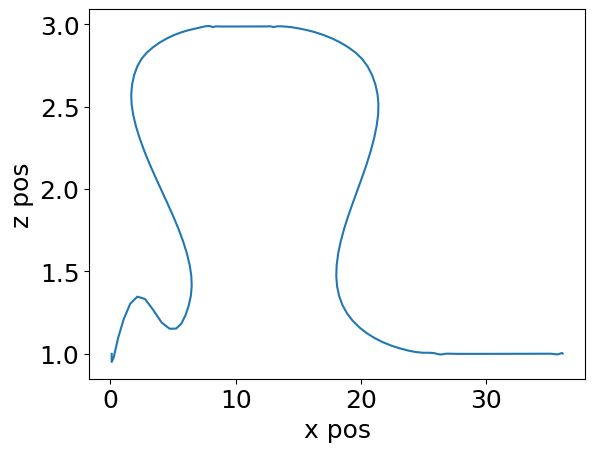

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

### Plot $\dot{x}$ vs time and $\dot{z}$ vs time.

Text(0, 0.5, 'x and z vel')

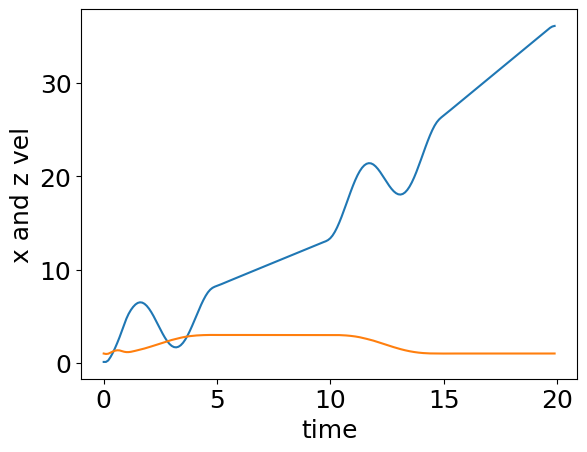

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_sim, x_sim['x'])
ax.plot(t_sim, x_sim['z'])

ax.set_xlabel('time')
ax.set_ylabel('x and z vel')

# Define noise characteristics

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [8]:
measurement_noise_stds = {'optic_flow': 1,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.2,
                          'accel_z': 0.2,
                          #'k': 0.1,
                         }

### Save data as dataframes

In [9]:
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

# Empirical observability analysis

We now have a trajectory, and the controls necessary to achieve that trajectory.

We need to perturb the initial condition of the system (one state at a time), and then simulate the system in **open loop--that is, no changes to the control inputs**, and then see how the measurements change. This allows us to calculate an empirical jacobian of the measurements with respect to the initial state.

Actually implementing this has many pitfalls. We cannot just naively use odeint, for example, because it chooses keypoints that will be different depending on the initial conditions!

The `pybounds` simulator object resolves that issue, among others, so we will use that built in simulator object.  

### Running pybounds simulator in open loop

Note: if you do not need MPC, you can also use this approach for your initial simulation. For example, if you have a kinematically defined system, you might opt for this option.

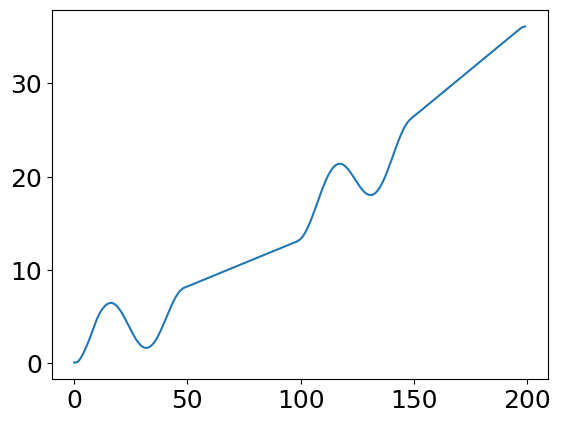

In [24]:
# Set initial state
x0 = x_sim_df.iloc[0]

# Run simulation using open-loop inputs
open_loop_sim = simulator.simulate(x0=x0, u=u_sim_df.values, return_full_output=True)

# Extract the states
open_loop_sim_x = open_loop_sim[1]

# Plot the x component -- it should match what we had above
plt.plot(open_loop_sim_x['x'])

### Perturb one state in the positive and negative direction

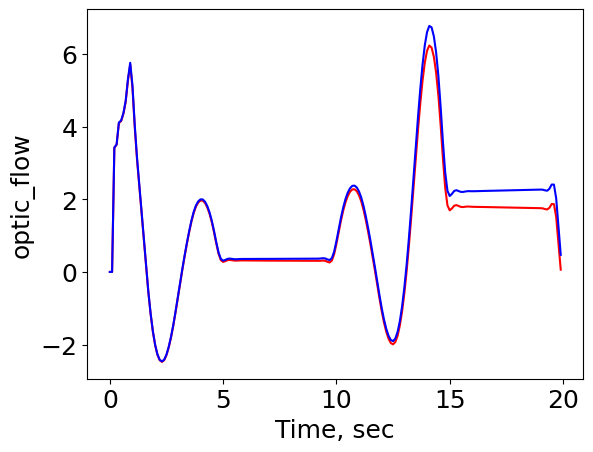

In [76]:
# Write as a function so we can reuse it
def perturb_state_and_simulate(simulator, state_to_perturb, plot=False):
    # Perturbation amount (should be small, but exact value does not matter much)
    eps = 1e-3

    # Perturbation vector
    e_vec = np.zeros((x_sim_df.shape[1]))
    e_vec[state_to_perturb] = eps

    # Perturb in positive direction
    x0 = x_sim_df.iloc[0] + e_vec
    open_loop_sim_plus = simulator.simulate(x0=x0, u=u_sim_df.values, return_full_output=True)
    open_loop_sim_y_plus = open_loop_sim_plus[3]

    # Perturb in negative direction
    x0 = x_sim_df.iloc[0] - e_vec
    open_loop_sim_minus = simulator.simulate(x0=x0, u=u_sim_df.values, return_full_output=True)
    open_loop_sim_y_minus = open_loop_sim_minus[3]

    # Plot the measurements for the positive and negative perturbation
    if plot:
      measurement_to_show = 'optic_flow'
      plt.plot(t_sim, open_loop_sim_y_plus[measurement_to_show], color='red')
      plt.plot(t_sim, open_loop_sim_y_minus[measurement_to_show], color='blue')
      plt.xlabel('Time, sec')
      plt.ylabel(measurement_to_show)

    return open_loop_sim_y_plus, open_loop_sim_y_minus

open_loop_sim_y_plus, open_loop_sim_y_minus = perturb_state_and_simulate(simulator, 0, plot=True)

### Plot the difference, this is $\delta Y_i / \delta x_i$

Text(0, 0.5, 'optic_flow change')

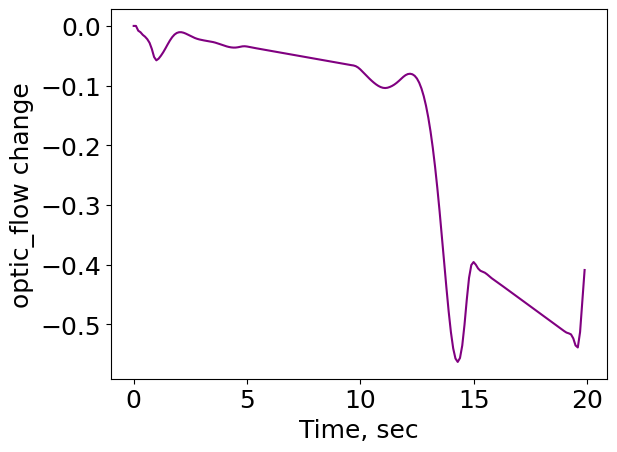

In [77]:
# Plot the difference between the measurements
plt.plot(t_sim, open_loop_sim_y_plus[measurement_to_show] - open_loop_sim_y_minus[measurement_to_show], color='purple')
plt.xlabel('Time, sec')
plt.ylabel(measurement_to_show + ' change')

### Make a vertical stack of all the measurements over time: $\delta Y / \delta x_i$

We can write it as a single column vector -- all the measurements for each time step stacked on top of each other.

In [78]:
# Note: this is actually a horizontal array, we will transpose it later to make it vertical as it should
dY_dxi = np.ravel(pd.DataFrame(open_loop_sim_y_plus).values) - np.ravel(pd.DataFrame(open_loop_sim_y_minus).values)

### Repeat for each individual state to make $\mathcal{O}$ -- the observability matrix

In [79]:
O = []
for i in range(x_sim_df.shape[1]):
  open_loop_sim_y_plus, open_loop_sim_y_minus = perturb_state_and_simulate(simulator, i)
  dY_dxi = np.ravel(pd.DataFrame(open_loop_sim_y_plus).values) - np.ravel(pd.DataFrame(open_loop_sim_y_minus).values)
  O.append(dY_dxi)
O = np.vstack(O).T

### Get the empirical observability Gramian $\mathcal{W_o}$ = $\mathcal{O}^T$$\mathcal{O}$

Remember, this is closely related to the Fisher Information.

In [80]:
W_o = O.T@O

### Plot $\mathcal{W_o^{-1}}$ -- something closely related to the Cramer Rao lower bound

This is effectively the Cramer Rao lower bound, assuming that all the measurements have a variance of 1, and the model is perfect.

The diagonal of this matrix is a good indicator of the level of observability for each individual state.

The off diagonals are less informative.

Since observability analyzes how well the initial condition can be estimated given the window of information provided, this says how well can $x_0$ be determined given all the measurements in $Y$.

/tmp/ipython-input-4209761820.py:3: RuntimeWarning: invalid value encountered in log
  img = plt.imshow(np.log(Finv), origin='upper')


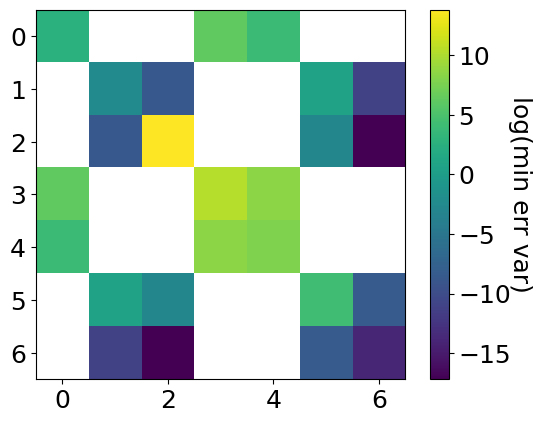

In [82]:
lam = 1e-6
Finv = np.linalg.inv(W_o + lam*np.eye(len(W_o)))
img = plt.imshow(np.log(Finv), origin='upper')

# Add the colorbar, referencing the AxesImage object 'im'
cbar = plt.colorbar(img)
cbar.set_label('log(min err var)', rotation=270, labelpad=15)

# Identify movements motifs that maximize observability

Run the analysis above for small windows, sliding across the trajectory. We will use pybounds to do that in the next notebook.